# General Configuration

The only additional package needed for this notebook is the "tabulate" library which is used for generating formatted tables of results. You should run the bellow cell only once. After this, it is recommended that the below cell is commented out.

In [1]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


#### Import dependencies and initialise random generator

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace, gmean
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model, preprocessing, svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tabulate import tabulate

In [3]:
# construct random generator 
rng = np.random.default_rng(12345)

# Task 1: Asian Options

In this notebook, we walk through the process of constructing and evaluating several methods of pricing a *Fixed Strike Asian Call Option with Discrete Arithmetic Average*.

The methods we will use are naive, antithetic variance reduction and several control variate methods.

### Local volatility

Our local volatility is defined as:

$\sigma(S,t) = \sigma_0(1 + \sigma_1\cos(2{\pi}t))(1 + \sigma_2\exp(\frac{-S}{50})))$

where $\sigma_0=0.2$, $\sigma_1=0.3$ and $\sigma_2=0.5$ and $t$ is in years.

The below function is a coded implementation of the above formula.

In [4]:
def local_volatility(S,t):
    sigma0 = 0.2
    sigma1 = 0.3
    sigma2 = 0.5
    
    sigma = sigma0*(1 + sigma1*np.cos(2*np.pi*t))*(1 + sigma2*np.exp(-S/50))
    
    return sigma

### Time-stepping

For efficiency and to reduce the amount of repeated code, we seperate the time-stepping operations into a seperate function. The function can handle time-stepping for different types of option pricing methods such as naive, antithetic variance reduction and control variates. The function takes as input:

- S0: Initial (today's) spot price
- t: Number of time steps
- dt: Size of spacing between time steps
- Nsteps: Number of days from now until time T where T is in years
- N_paths: Number of paths to simulate
- Method: flag that determins which type of time-stepper should be executed (Naive, Antithetic or Control Variate)

In [5]:
def time_stepper(S0, t, dt, Nsteps, N_paths, method):
    # Naive time-stepper
    if method == "naive":
        S = np.zeros((Nsteps + 1, Npaths))
        S[0,:] = S0
        for n in range(Nsteps):
            sigma = local_volatility(S[n],t[n])
            dW = np.sqrt(dt) * rng.normal(0,1,Npaths)
            S[n+1,:] = S[n,:] * (1. + r*dt + sigma * dW[:])
        
        return S
    
    # Antithetic time-stepper
    elif method == "antithetic":
        S_plus = np.zeros((Nsteps + 1, Npaths))
        S_minus = np.zeros((Nsteps + 1, Npaths))
        S_plus[0,:] = S0
        S_minus[0,:] = S0
        for n in range(Nsteps):
            sigma_plus = local_volatility(S_plus[n],t[n])
            sigma_minus = local_volatility(S_minus[n],t[n])
            dW = np.sqrt(dt) * rng.normal(0,1,Npaths)
            S_plus[n+1,:] = S_plus[n,:] * (1. + r*dt + sigma_plus * dW[:])
            S_minus[n+1,:] = S_minus[n,:] * (1. + r*dt - sigma_minus * dW[:])
        
        return S_plus, S_minus
    
    # Control variate time-stepper
    elif method == "control_variate":
        S = np.zeros((Nsteps + 1, Npaths))
        Z = np.zeros((Nsteps + 1, Npaths))
        S[0,:] = S0
        Z[0,:] = S0
        for n in range(Nsteps):
            dW = np.sqrt(dt) * rng.normal(0,1,Npaths)
            Z[n+1,:] = Z[n,:] * (1. + r*dt + local_volatility(S0,0) * dW[:])
            S[n+1,:] = S[n,:] * (1. + r*dt + local_volatility(S[n],t[n]) * dW[:])
        
        return S, Z
        
    else:
        return "Error, method not supported"

### Payoff
The payoff function for a fixed strike Asian call option with discrete arithmetic average is given by:

$max(\frac{1}{N}\sum_{n=1}^N S_n - K, 0)$,

where $N$ is the number of steps, $S_n$ is the sequence of daily closing prices of the underlying and $K$ is the fixed strike price.

The coded implementation of the payoff function is below.

In [6]:
def payoff(S, K, r, T):
    return np.exp(-r*T)*np.maximum(np.mean(S,axis=0) - K, 0)

### Asian option pricing

Now we define the functions for computing the price and variance of an Asian option using naive, antithetic and several control variate methods.

#### Naive pricing

Naive pricing is a relatively simple Monte-Carlo based method for estimating the value of an option. In this case, the method is estimates the value by simulating $Npaths$ over the option's lifespan and creates a distribution of discounted payoffs from which the mean is taken to be the value estimate.

The coded implementation of this method is below.

In [7]:
def asian_call_naive(S0, K, T, r, Npaths):
    Nsteps = int(260 * T)
    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)
    
    # Generate S from the time-stepper function
    S = time_stepper(S0, t, dt, Nsteps, Npaths, method="naive")
    
    # Compute discounted payoff
    fS = payoff(S, K, r, T)
    
    # Compute price and variance
    price = np.mean(fS)
    variance = np.var(fS)
    
    return price, variance

#### Antithetic pricing

Antithetic pricing is also a Monte-Carlo based method but the difference between antithetic and naive is that the antithetic method simulates pairs of antithetic paths which are negatively correlated with eachother. This helps to cancel out some of the statistical noise in the simulations resulting in lower variance value estimates.

The coded implementation of this method is below.

In [8]:
def asian_call_antithetic(S0, K, T, r, Npaths):
    Nsteps = int(260 * T)    
    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)       
    Z = np.zeros(Npaths)         
    
    # Generate S+ and S- from the time-stepper function
    S_plus, S_minus = time_stepper(S0, t, dt, Nsteps, Npaths, method="antithetic")     
    
    # Generate discounted payoffs of S+ and S-
    fS_plus = payoff(S_plus, K, r, T)
    fS_minus = payoff(S_minus, K, r, T)

    # Generate Z (average of pairs of antithetic paths)
    for i in range(len(fS_plus)):
        Z[i] = (fS_plus[i] + fS_minus[i])/2
    
    # Calculate price and variance
    price = np.mean(Z)
    variance = np.var(Z)
    
    return price, variance

#### Black Scholes European Call

Below we have the function taken from the seminar resources for computing the Black Scholes formula which is used to calculate the sample mean in control variate 2.

In [9]:
def BS_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2 /2) * T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

#### Control variate pricing

Control variate methods are designed to reduce the variance in option valuations. The basic principles are that a control variate is chosen, which should be correlated with the Asian option value. Then the expected value of the Asian option is estimated using Monte-Carlo simulation. Next, we calculate the expected value of the control variate and use the expected value of the Asian option and control variate to compute the control variate coefficient, which is a measure of the correlation between the two objects. Finally, the control variate is used to adjust the computed value of the Asian option which is the key step that reduces variance in the estimate.

The first control variate is simply $Z_T$.

In [10]:
def asian_call_cv1(S0, K, T, r, Npaths):
   
    Nsteps = int(260 * T)
    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)
    S, Z = time_stepper(S0, t, dt, Nsteps, Npaths, method="control_variate")
    
    # Compute sample mean and var
    sigma = local_volatility(S0,0)
    mean_ST = S0*np.exp(r*T)
    var_ST = mean_ST**2 * (np.exp(sigma**2*T)-1)
    
    # Compute the covariance and coefficient c
    fST = payoff(S, K, r, T)
    cov_fST_ST = np.mean(fST*Z[-1,:])-np.mean(fST)*np.mean(Z[-1,:])
    c = cov_fST_ST/var_ST
    
    # Compute the adjusted discounted payoff
    fc = fST-c*(Z[-1,:]-mean_ST)                    
    
    # Compute the price and variance
    price = np.mean(fc)
    variance = np.var(fc)
    
    return price, variance

The second control variate is $e^{rT}max(Z_T - K, 0)$

Here we use slightly different notation to make it clearer when we are working with the European option and the Asian option. Notice also that the $var$ calculation is different to the other methods in this notebook since we are now considering a European call option.

In [11]:
def asian_call_cv2(S0, K, T, r, Npaths):
    Nsteps = int(260 * T)
    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)
    S, Z = time_stepper(S0, t, dt, Nsteps, Npaths, method="control_variate")
    
    sigma = local_volatility(S0,0)                              # constant volatility
    mean = BS_call(S0,K,T,r,sigma)                              # compute mean via Black Scholes
    var = S**2 * np.exp(2*r*T)*(np.exp(sigma**2*T)-1)           # var for European call
    
    # Generate the discounted payoffs (value) of both the European and Asian options
    eurPrice = payoff(Z[-1,:],K,r,T)
    optPrice = payoff(S,K,r,T)
    
    # Compute the covariance
    eurMean, eurVar = np.mean(eurPrice), np.var(eurPrice)
    covOpt = np.mean(optPrice*eurPrice) - np.mean(optPrice)*eurMean
    
    # Here we check if the variance of the control variate is zero in which case, reducing variance is unnecessary so we set c to zero
    if eurVar == 0:
        c = 0
    else:
        c = covOpt / var
    
    # Compute the adjusted discounted payoff
    fc = optPrice - c*(eurPrice - mean)
    
    # Compute price and variance
    price = np.mean(fc)
    variance = np.var(fc)
    
    return price, variance

The third control variate is $max((\prod_{n=0}^N Z_n)^{\frac{1}{N+1}}-K, 0)$

In this method, we use the discounted payoff for a geometrical averaged Asian option where the expectation is given by:

$Z_0exp((r_g - r)T)N(d_1)-Kexp(-rT)N(d_2)$

$d_1 = \frac{\log\frac{Z_0}{K} + r_g + \frac{1}{2}\sigma_g ^2T}{\sigma_g \sqrt(T)}$

In [12]:
def asian_call_cv3(S0, K, T, r, Npaths):
   
    Nsteps = int(260 * T)
    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)
    S, Z = time_stepper(S0, t, dt, Nsteps, Npaths, method="control_variate")
    
    sigma = local_volatility(S0,0)
    
    # Here we set up the variables needed to compute the expectation as given in the formula above
    vol_geo = sigma*np.sqrt((2*Nsteps+1)/6*(Nsteps+1))
    r_geo = (1/2)*(r-(1/2)*vol_geo**2)
    d1 = (np.log(S0/K) + (r_geo + (1/2)*vol_geo**2)*T)/(vol_geo*np.sqrt(T))
    d2 = d1 -  vol_geo * np.sqrt(T)
    
    # Compute mean and var of S
    mean_ST = S0*np.exp((r_geo-r)*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    var_ST = mean_ST**2 * (np.exp(sigma**2*T)-1)
    
    # As per the methodology, compute geometric mean and the covariance
    fST = np.maximum(gmean(S)-K,0)
    cov_fST_ST = np.mean(fST*Z[-1,:]) - np.mean(fST)*np.mean(Z[-1,:])
    
    # Here we check if the variance of the control variate is zero in which case, reducing variance is unnecessary so we set c to zero
    if var_ST == 0:
        c = 0
    else:
        c = cov_fST_ST / var_ST
    
    # Compute the adjusted discounted payoff
    f_c = fST-c*(Z[-1,:]-mean_ST)
    
    # Compute the price and variance
    price = np.mean(f_c)
    variance = np.var(f_c)
    
    return price, variance

### Method evaluation

#### Define the input arguments for testing:

In [13]:
K= 110            #strike price
r= 0.05           #interst rate
Npaths= 1000      #No. of paths
S0 = 100          #starting price
T = 3             #time in years

#### Comparison table

Here we generate results tables that are used to compare the various methods in three different scenarios; S0=100<K, S0=110=K and S0=120>K.

In [14]:
# Define number of test runs required and initialise the matrices to store results
Ntests = 10
naive_matrix = np.zeros((3,Ntests))
antithetic_matrix = np.zeros((3,Ntests))
cv1_matrix = np.zeros((3,Ntests))
cv2_matrix = np.zeros((3,Ntests))
cv3_matrix = np.zeros((3,Ntests))

S0 = [90,110,130]
print(f"\nThe below results were generated by taking the mean of {Ntests} runs of each method:\n")
for S in S0:
    # Populate results matrices for each of the test runs
    for i in range(0,Ntests):
        naive_matrix[0,i], naive_matrix[1,i] = asian_call_naive(S, K, T, r, Npaths)
        naive_matrix[2,i] = np.sqrt(naive_matrix[1,i]/Npaths)
        antithetic_matrix[0,i], antithetic_matrix[1,i] = asian_call_antithetic(S, K, T, r, Npaths)
        antithetic_matrix[2,i] = np.sqrt(antithetic_matrix[1,i]/Npaths)
        cv1_matrix[0,i], cv1_matrix[1,i] = asian_call_cv1(S, K, T, r, Npaths)
        cv1_matrix[2,i] = np.sqrt(cv1_matrix[1,i]/Npaths)
        cv2_matrix[0,i], cv2_matrix[1,i] = asian_call_cv2(S, K, T, r, Npaths)
        cv2_matrix[2,i] = np.sqrt(cv2_matrix[1,i]/Npaths)
        cv3_matrix[0,i], cv3_matrix[1,i] = asian_call_cv3(S, K, T, r, Npaths)
        cv3_matrix[2,i] = np.sqrt(cv3_matrix[1,i]/Npaths)

    if S<K:
        print("\n\nThis is the S0<K case:")
    elif S==K:
        print("\n\nThis is the S0=K case:")
    else:
        print("\n\nThis is the S0>K case:")
    print(f"S0 = {S}")
    
    # Generate results table
    Rtable = [['Method', 'Average price', 'Average SEM', '+/-'],
            ['Naive', round(np.mean(naive_matrix[0,:]),3), round(np.mean(naive_matrix[2,:]),3), round(1.96*np.mean(naive_matrix[2,:]),2)],
            ['Antithetic', round(np.mean(antithetic_matrix[0,:]),3), round(np.mean(antithetic_matrix[2,:]),3), round(1.96*np.mean(antithetic_matrix[2,:]),2)],
            ['Control variate 1', round(np.mean(cv1_matrix[0,:]),3), round(np.mean(cv1_matrix[2,:]),3), round(1.96*np.mean(cv1_matrix[2,:]),2)],
            ['Control variate 2', round(np.mean(cv2_matrix[0,:]),3), round(np.mean(cv2_matrix[2,:]),3), round(1.96*np.mean(cv2_matrix[2,:]),2)],
            ['Control variate 3', round(np.mean(cv3_matrix[0,:]),3), round(np.mean(cv3_matrix[2,:]),3), round(1.96*np.mean(cv3_matrix[2,:]),2)]]

    
    print(tabulate(Rtable, headers='firstrow', tablefmt='fancy_grid'))


The below results were generated by taking the mean of 10 runs of each method:



This is the S0<K case:
S0 = 90
╒═══════════════════╤═════════════════╤═══════════════╤═══════╕
│ Method            │   Average price │   Average SEM │   +/- │
╞═══════════════════╪═════════════════╪═══════════════╪═══════╡
│ Naive             │           3.648 │         0.291 │  0.57 │
├───────────────────┼─────────────────┼───────────────┼───────┤
│ Antithetic        │           3.631 │         0.188 │  0.37 │
├───────────────────┼─────────────────┼───────────────┼───────┤
│ Control variate 1 │           3.587 │         0.195 │  0.38 │
├───────────────────┼─────────────────┼───────────────┼───────┤
│ Control variate 2 │           3.659 │         0.291 │  0.57 │
├───────────────────┼─────────────────┼───────────────┼───────┤
│ Control variate 3 │           3.655 │         0.293 │  0.57 │
╘═══════════════════╧═════════════════╧═══════════════╧═══════╛


This is the S0=K case:
S0 = 110
╒═══════════════════

Comparing the results of the various methods, several conclusions can be drawn.

1. The Naive method results in relatively high variance diminishing the accuracy of it's pricing however, an advantage to it is that it is very easy to implement and so could be a good option for options with simpler payoff structures

2. The Antithetic method results in the lowest variance meaning that the accuracy of it's pricing is superior to the Naive method. This is a feature of the methodology which reduces the variance of Monte Carlo estimates in most cases

3. Surpisingly, all three control variates resulted in poorer levels of variance when compared to the antithetic method and considering the complexity of their methodologies, are likely not a good option in this scenario. Out of all three control variates howver, control variate 1 displayed the lowest variance whilst control variate 3 displayed the highest variacnce. This could be because first control variate has a higher correlation with the Asian option and therefore the variance reduction step has a greater effect on the overall estimate.


### Plotting option price as a function of spot price

Below we use the antithetic method (since it is the lowest variance method) to plot option value as a function of spot prices ranging from 10 to 180.

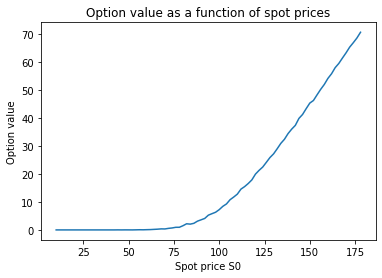

In [15]:
S0 = np.arange(10, 180, 2)
opt_val = []

for S in S0:
    ST = asian_call_antithetic(S, K, T, r, Npaths)
    opt_val.append(ST[0])

plt.plot(S0, opt_val)
plt.xlabel("Spot price S0")
plt.ylabel("Option value")
plt.title("Option value as a function of spot prices")
plt.show()

Looking at the above plot, we see that the option value is deep out of the money from spot price 10 to 75 and in this range, the option value remains relatively flat and close to zero. After this point, the gradient continues to increase sharply. This corresponds with the below delta plot as the option value becomes more sensitive to changes in the underlying price as the underlying price approaches and surpasses the strike price.

### Deltas

Below is a function that computes the pathwise delta for a given spot price S0.

In [16]:
def MC_asian_call_delta_pathwise(S0, K, T, r, Npaths):
    Nsteps = int(260 * T)
    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)
    S = time_stepper(S0, t, dt, Nsteps, Npaths, method="naive")
    
    # Get the first and last values of S (S0 and ST)
    S0 = S[0,:]
    ST = S[-1,:]
    
    # Compute the delta sequence using a heaviside step function
    Z = np.exp(-r*T) * (ST/S0) * np.heaviside(np.mean(S,axis=0)-K,0)
    
    delta = np.mean(Z)
    variance = np.var(Z)
    
    return delta

Now we plot the deltas using the naive timestepper over a series of spot prices ranging from 10 to 180

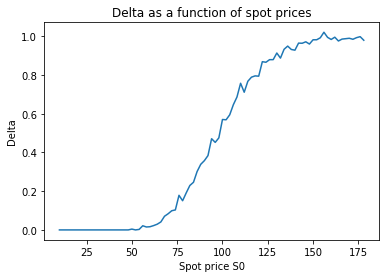

In [17]:
S0 = np.arange(10, 180, 2)
deltas = []

for S in S0:
    delta = MC_asian_call_delta_pathwise(S, K, T, r, Npaths)
    deltas.append(delta)
    
plt.plot(S0,deltas)
plt.xlabel("Spot price S0")
plt.ylabel("Delta")
plt.title("Delta as a function of spot prices")
plt.show()

A pathwise delta is a measure of how sensitive the option price is to changes in the underlying asset price. For example, if an option has delta of 0.8 then if the underlying asset price increases by £1, then the option value will increase by £0.80. We can see that the delta increases sharply from underlying prices 10 to 125 at which point it begins to plateau.